In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tqdm import tqdm, trange


from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
xlabels=pd.read_csv("train_labels.csv")
xlabels.head()

,id,label
0,0,1
1,1,13
2,2,13
3,3,14
4,4,6


In [6]:
train_image_dir="./train/train"
valid_image_dir="./validation/validation/"

In [7]:
train_image_file_paths = [ os.path.join(train_image_dir, x) for x in os.listdir(train_image_dir)]
valid_image_file_paths = [ os.path.join(valid_image_dir, x) for x in os.listdir(valid_image_dir)]

In [14]:
def find_file_id(path):
    file_id = int(os.path.splitext(os.path.basename(path))[0])
    return file_id

def find_image_label(path):
    file_id = find_file_id(path)
    return (xlabels[xlabels.id==file_id]).values[0][1]


print("Path:", train_image_file_paths[0])
print("File ID:", find_file_id(train_image_file_paths[0]))
print("Label:", find_image_label(train_image_file_paths[0]))

Path: ./train/train\0.tif
File ID: 0
Label: 1


In [15]:
y_labels = [find_image_label(x) for x in train_image_file_paths]
y_labels[:10]

[1, 13, 8, 10, 2, 1, 11, 15, 1, 1]

Text(0.5, 1.0, 'Distribution of different classes')

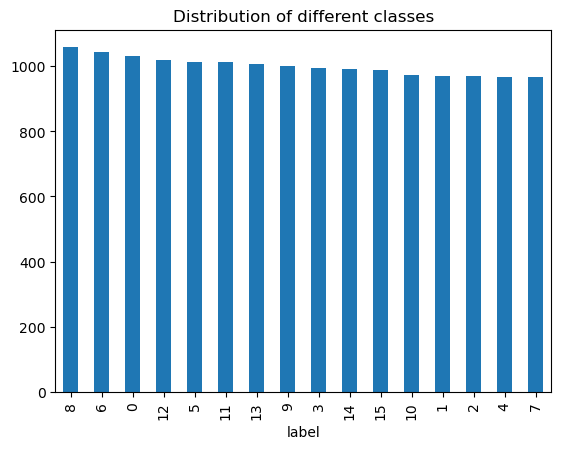

In [16]:
fig,ax = plt.subplots(figsize=(6.4,4.8),dpi=100)
ax =  xlabels['label'].value_counts().plot(kind="bar")
plt.title("Distribution of different classes")

./train/train\10005.tif (1000, 757) 4


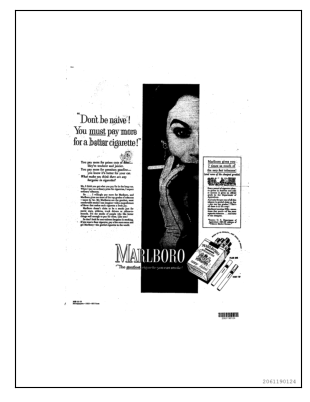

In [17]:
figure(figsize=(5, 5), dpi=100)
idx = 10
sample = train_image_file_paths[idx]
sample_img = io.imread(sample)
print(sample, sample_img.shape, y_labels[idx])
fig = plt.imshow(sample_img, cmap='gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

In [18]:
len(train_image_file_paths), xlabels.shape[0]

(16000, 16000)

In [19]:
def prep_train_feature_data(paths, dim=(100,100)):
    total=len(paths)
    x = np.zeros((total, dim[0], dim[1], 1), dtype='float')
    for i,path in (enumerate((paths))):
        img = io.imread(path)/255.0
        img =  resize(img, (dim[0], dim[1]))
        img = img.reshape((dim[0], dim[1]))
        x[i,:,:,0] = img
    return x

In [20]:
from tensorflow import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, paths, batch_size=32, dim=(300, 300)):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.paths = paths

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.paths)//self.batch_size

    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch
        index_start = idx*self.batch_size
        index_end = (idx+1)*self.batch_size

        sub_paths = self.paths[index_start:index_end]
        
        X = prep_train_feature_data(sub_paths, self.dim)
        y = [find_image_label(path) for path in sub_paths]

        return X, np.array(y)

In [21]:
n_classes=len(set(y_labels))
image_size = (300, 225)

In [22]:
from sklearn.model_selection import train_test_split
train_paths,valid_paths,train_labels,valid_labels = train_test_split(train_image_file_paths , y_labels , stratify = y_labels , test_size = 0.1)

In [23]:
train_paths,test_paths,train_labels,test_labels = train_test_split(train_paths , train_labels , stratify = train_labels , test_size = 0.15)

In [24]:
validation_data = prep_train_feature_data(valid_paths, image_size)
validation_preds = np.array(valid_labels)
validation = (validation_data, validation_preds)

In [25]:
test_data=prep_train_feature_data(test_paths,image_size)

In [27]:
input_shape = image_size
input_shape = input_shape + (1,)
inputs = keras.Input(input_shape)


In [28]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
import tensorflow.keras.callbacks
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from sklearn.metrics import accuracy_score

inputs = keras.Input(shape=input_shape)

x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2),strides = 2)(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2),strides = 2)(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2),strides = 2)(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2),strides = 2)(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)

outputs = layers.Dense(16, activation="softmax")(x) 
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 225, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 298, 223, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 298, 223, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 149, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 109, 64)      18496 

In [29]:
opt = Adam(learning_rate = 0.001)
model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True #restoring the best model
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                              patience=2,
                              verbose=1,
                              min_delta=0.001)
callbacks = [early_stopping,checkpoint,reduce_learningrate]

epochs = 15

In [31]:
train_generator = DataGenerator(train_paths, batch_size=64, dim=image_size)

In [32]:
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation,
    callbacks=callbacks
)

Epoch 1/15
191/191 [==============================] - 1038s 5s/step - loss: 2.3131 - accuracy: 0.3585 - val_loss: 34.7116 - val_accuracy: 0.0675 - lr: 0.0010
Epoch 2/15
191/191 [==============================] - 3879s 20s/step - loss: 1.6870 - accuracy: 0.5063 - val_loss: 22.2801 - val_accuracy: 0.0975 - lr: 0.0010
Epoch 3/15
191/191 [==============================] - 1857s 10s/step - loss: 1.3921 - accuracy: 0.5964 - val_loss: 4.6757 - val_accuracy: 0.1094 - lr: 0.0010
Epoch 4/15
191/191 [==============================] - 1731s 9s/step - loss: 1.2227 - accuracy: 0.6426 - val_loss: 13.0210 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 5/15
191/191 [==============================] - 1098s 6s/step - loss: 1.0122 - accuracy: 0.7011 - val_loss: 1.9209 - val_accuracy: 0.4956 - lr: 0.0010
Epoch 6/15
191/191 [==============================] - 986s 5s/step - loss: 0.8287 - accuracy: 0.7543 - val_loss: 4.9153 - val_accuracy: 0.2788 - lr: 0.0010
Epoch 7/15
191/191 [==============================] - 

In [33]:
model.save("cnn.h5")

c:\Users\Dell\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
from tensorflow.keras.models import load_model
model = load_model("cnn.h5")

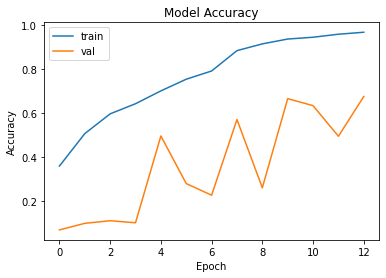

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

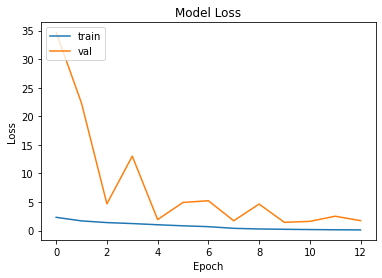

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [37]:
from sklearn.metrics import accuracy_score, classification_report

y_test_res = model.predict(test_data)
test_prediction = []
for i in range(test_data.shape[0]):
    idx = np.argmax(y_test_res[i])
    test_prediction.append(idx)

68/68 [==============================] - 28s 406ms/step


In [38]:
test_actual = np.array(test_labels)
accuracy = accuracy_score(test_actual,test_prediction)
print(accuracy)

0.6555555555555556


In [39]:
print(classification_report(test_actual,test_prediction))

              precision    recall  f1-score   support

           0       0.75      0.50      0.60       139
           1       0.35      0.69      0.47       131
           2       0.58      0.96      0.72       131
           3       0.93      0.69      0.79       134
           4       0.81      0.66      0.73       130
           5       0.44      0.39      0.42       137
           6       0.75      0.82      0.78       141
           7       0.91      0.70      0.79       130
           8       0.69      0.93      0.79       143
           9       0.85      0.63      0.72       135
          10       0.52      0.51      0.52       132
          11       0.76      0.50      0.60       136
          12       0.61      0.54      0.57       138
          13       0.79      0.47      0.59       136
          14       0.73      0.83      0.78       134
          15       0.61      0.68      0.64       133

    accuracy                           0.66      2160
   macro avg       0.69   

In [40]:
classes = list(range(16))
res = tf.math.confusion_matrix(test_prediction,test_actual).numpy()
cm = pd.DataFrame(res,
                     index = classes, 
                     columns = classes)

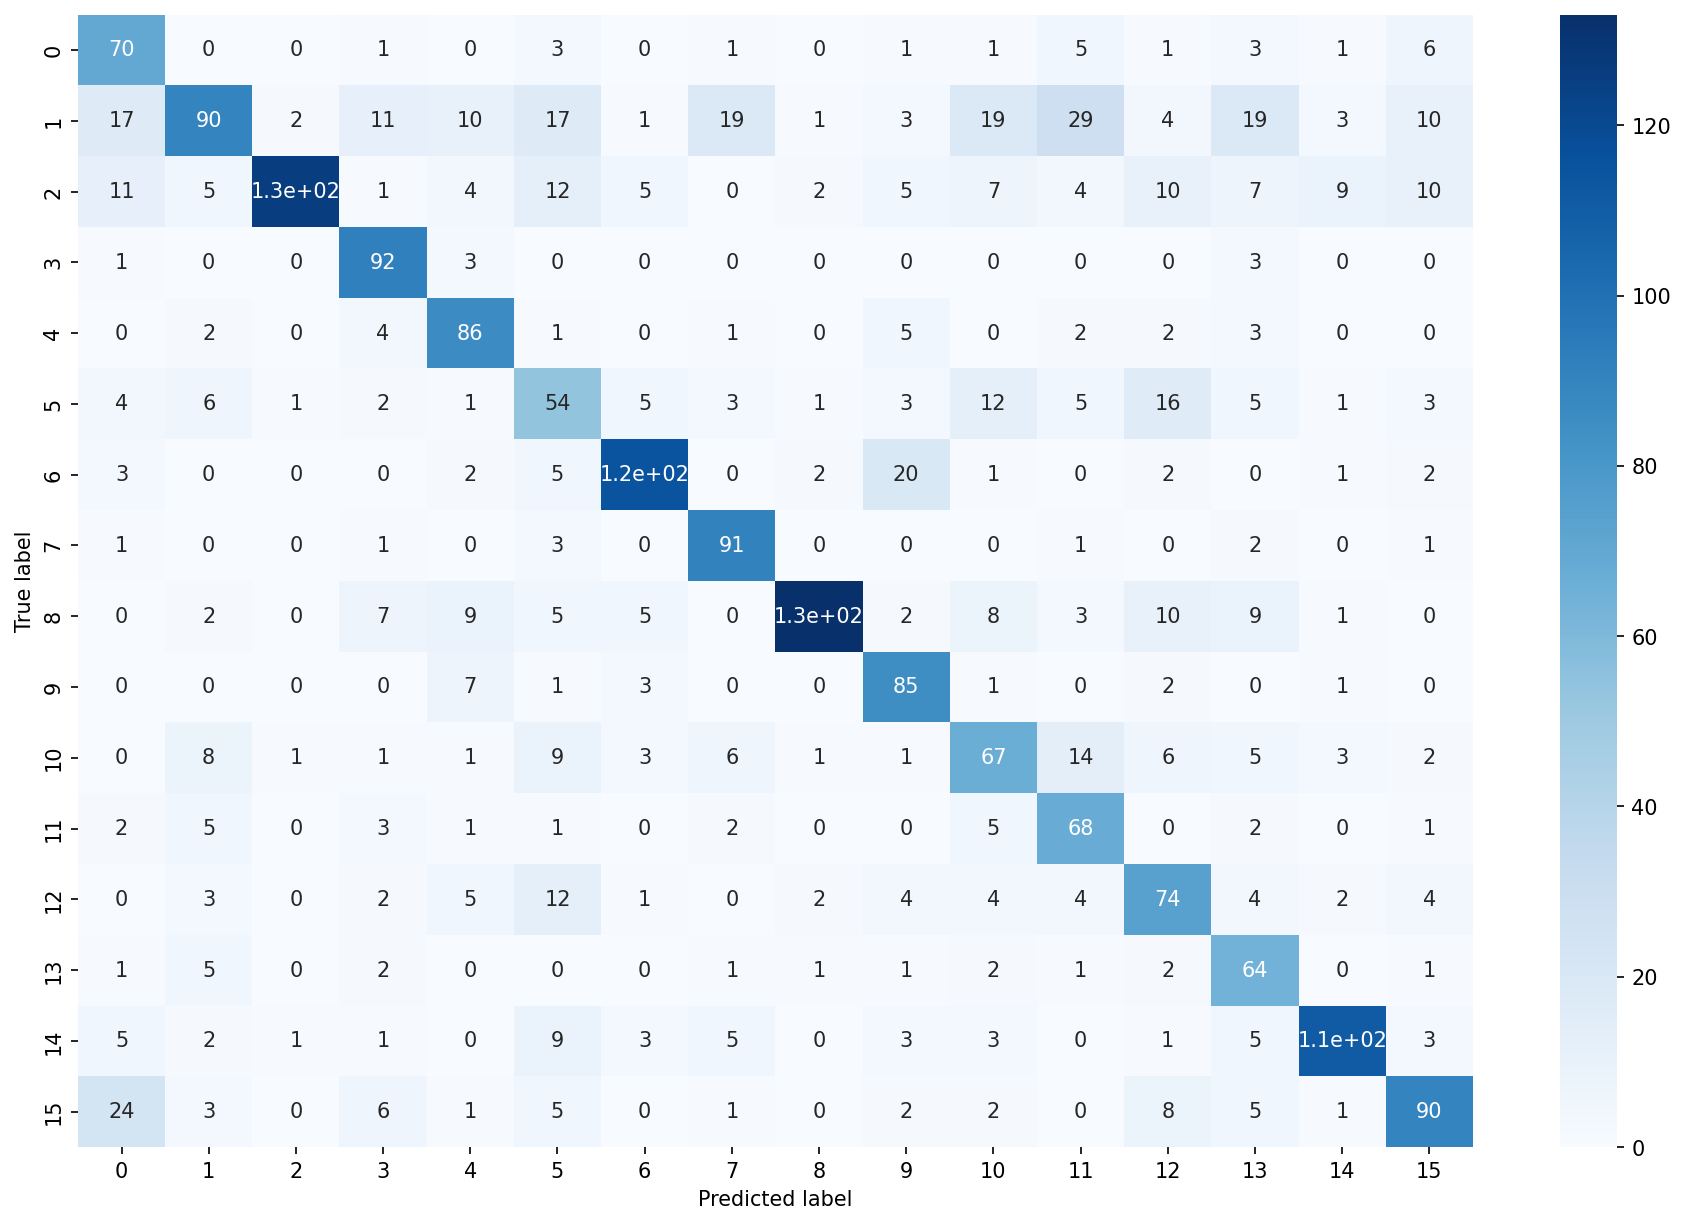

In [41]:
import seaborn as sns
figure = plt.figure(figsize=(15, 10), dpi=150)
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()